<a href="https://colab.research.google.com/github/BinarPlatinumChallenge/Sentiment-Analysis/blob/main/NN-LSTM_collabs/1_NeuralNetwork_BOW_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREPARE DATASET**

In [ ]:
# mounting to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download dataset

Raw data traning can be downloaded with this [link](https://drive.google.com/file/d/1RCHGfn9JJyyReAh8PIIoF8Ch0H3miP0u/view)

Raw data set hates speech, file kamus alay dan stopwords can be downloaded in this [link](https://drive.google.com/drive/folders/1qm50pKAnzGGw9gtk--lmwR758aZOVish) 

In [ ]:
# Libraries to read and analyze data frame
# read raw dataset used for training the model from google drive, eliminated null and duplicated data

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/train_preprocess.tsv.txt', delimiter='\t', header=0, names=['tweet','sentimen'])
df = df.dropna()
df = df.drop_duplicates(ignore_index=True)

In [ ]:
# Install libraries for stopwords

!pip install nltk
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 14.6 MB/s eta 0:00:00


In [ ]:
# import library to handle stopwords using NLTK

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words=(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# import library to handle stopwords using sastrawi

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stop_factory = StopWordRemoverFactory()
sastrawi_stop_words = stop_factory.get_stop_words()
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
# merge stopword dictionary from NLTK, sastrawi, and raw file "stopwordbahasa.csv"
# add {'ya','yg','ga','yuk','dah','sih','gue','nya','nih'} in stopwords dict set
# eliminated word ['tidak'] from stopwords dict set to avoid changing the meaning of the sentence 

stopword_dict = pd.read_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/stopwordbahasa.csv', header=None, names=['stopword'], encoding='latin-1')
stopword_dict = list(stopword_dict['stopword']) + sastrawi_stop_words + stop_words + ['ya','yg','ga','yuk','dah','sih','gue','nya','nih']
stopword_dict = list(dict.fromkeys(stopword_dict))
stopword_dict = filter(lambda word: word !='tidak', stopword_dict)
stopword_dict = list(stopword_dict)
print(len(stopword_dict))

781


## CLEANSING DATA SET

In [ ]:
# Cleansing dataset using RegEx
# text cleansing definition

import re 
def lowercase(text): #1 lowecase
  text = text.strip() 
  return text.lower()

def remove_unnecessary_char(text): #2
  text = re.sub('\\+n', ' ', text) # remove every new line
  text = re.sub('\n'," ",text) # remove every single new line
  text = re.sub('\\+', ' ', text) # remomove unessessary character
  text = re.sub(r'\brt\b','', text) # r'\b...\b to remove certain word, only at the beginning or end of the word for 'rt' 
  text = re.sub(r'\buser\b','', text) # r'\b...\b to remove certain word, only at the beginning or end of the word for 'user'
  text = re.sub(r'\burl\b','', text)
  text = re.sub(r'\bnurl\b','', text)
  text = re.sub('&lt;/?[a-z]+&gt;', '', text) #remove special characters
  text = re.sub('&amp', '', text) #remove ampersand character
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # remomove unessessary character 
  text = re.sub(':', ' ', text) # remomove special character 
  text = re.sub(';', ' ', text) 
  text = re.sub('  +', ' ', text) 
  text = re.sub(r'pic.twitter.com.[\w]+', '', text) # remomove unessessary character 
  text = re.sub(r'[^\x00-\x7F]+',' ', text)  
  text = re.sub(r'‚Ä¶', '', text)  
  to_delete = ['hypertext', 'transfer', 'protocol', 'over', 'secure', 'socket', 'layer', 'dtype', 'tweet', 'name', 'object'
                 ,'twitter','com', 'pic'] # delete another unessessary words
  for word in to_delete: 
      text = re.sub(word,'', text) # remove extra space
      text = re.sub(word.upper(),' ',text)
  return text

def remove_nonaplhanumeric(text): #3
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def remove_emoticon_byte(text): #4
    text = text.replace("\\", " ")
    text = re.sub(r'\bx..', ' ', text)
    text = re.sub(' n ', ' ', text)
    return text

def remove_early_space(text):  #5
    if text[0] == ' ':
        return text[1:]
    else:
        return text

def remove_number(text): #6
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

# handle special word "tidak" --> "tidak_" to avoid changing the meaning of the sentance

def handleTidak(text): #7
    words = text.split(' ')
    text = ' '.join(['tidak_' if words[i] == 'tidak' else words[i] for i in range(len(words))])
    text = text.strip()
    text = text.replace('tidak_ ','tidak_')
    return text


In [ ]:
# text normalization 

def normalize_alay(text): #8
    alay_dict = pd.read_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/new_kamusalay.csv', names=['original', 'replacement'], encoding='latin-1')
    alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
    normalize_text = ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])
    return normalize_text

def remove_stopword(text): #9
    text = ' '.join(['' if word in stopword_dict else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

def stemming(text): #10
    return stemmer.stem(text)

In [ ]:
# text cleansing process

def cleanse_text(text):
    text = lowercase(text) #1
    text = remove_unnecessary_char(text) #2
    text = remove_nonaplhanumeric(text) #3
    text = remove_emoticon_byte(text) #4
    text = remove_early_space(text) #5
    text = remove_number(text) #6
    text = normalize_alay(text) #8
    text = remove_stopword(text) #9
    text = stemming(text) #10
    text = handleTidak(text) #7
    return text


In [ ]:
# # check cleansing result

text = 'RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'
text = cleanse_text(text)
text

'telat tau gila sarap gaul cigax jifla cal licew'

In [ ]:
# applied data cleansing process into dataframe

df['cleaned_tweet'] = df.tweet.apply(cleanse_text)

In [ ]:
# save clean dataset to google drive

df.to_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/train_cleaned_preprocess.csv', header = True)
df.head()

,tweet,sentimen,cleaned_tweet
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k mmbri hujjah partai diwlh ...
1,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nyaman ...
2,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia unboxing paket barang bagus tet...
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning ajar...
4,"makanan beragam , harga makanan di food stall ...",positive,makan agam harga makan food stall kasir suasan...


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/train_cleaned_preprocess.csv', header=0)
df = df.dropna()
df = df.drop_duplicates(ignore_index=True)

## Cheking cleansing result


In [ ]:
# checking the frequency of words

new_df = df.cleaned_tweet.str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 
new_df.head(10)

,Word,Frequency
0,makan,6458
1,enak,3684
2,harga,2001
3,bandung,1746
4,menu,1735
5,banget,1511
6,restoran,1300
7,layan,1260
8,pilih,1260
9,jalan,1013


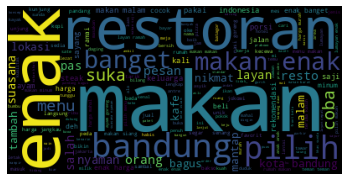

In [ ]:
# checking the frequency of words using matplotlib and WordCloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = ' '.join(df['cleaned_tweet'])
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# FEATURE EXTRACTION : BoW

In [ ]:
# Convert a given array to an ordinary list with the same items, elements, or values

data_clean = df.cleaned_tweet.tolist()

In [ ]:
# Sklearn CountVectorizer to convert a collection of text documents to a vector of term/token counts

from sklearn.feature_extraction.text import CountVectorizer

# Feature Extraction processing
count_vect = CountVectorizer()
count_vect.fit(data_clean)

# result definition 
text_transform = count_vect.transform(data_clean)
print ("Feature Extraction : done")

Feature Extraction : done


In [ ]:
# Serializing and deserializing a Python object structure
# Converting a Python object into a byte stream to store it in a file/database
# Saved feature extraction process

import pickle
pickle.dump(count_vect, open("/content/drive/MyDrive/CHALLENGE_PLATINUM/bow_feature.pickle", "wb"))

# DATA TRAINING

In [ ]:
# import package to split data train and test

from sklearn.model_selection import train_test_split

# define sentimen classification
sentimen_classes = df.sentimen

In [ ]:
# Split data set for model training (80%) and testing (20%)

X_train, X_test, y_train, y_test = train_test_split(text_transform, sentimen_classes, test_size = 0.2, random_state=0)

In [ ]:
# Import package for neural network model training 
from sklearn.neural_network import MLPClassifier

# define model and choose optimal parameter values
def createModel():
  model = MLPClassifier(hidden_layer_sizes=(120, 80, 40), max_iter = 300, activation='relu', solver = 'adam')
  # model = MLPClassifier(hidden_layer_sizes=(200, 150, 100), max_iter=250, activation = 'relu',solver='adam',random_state=2)
  # model = MLPClassifier(hidden_layer_sizes=(150, 100), max_iter = 300,activation = 'relu', solver = 'adam')
  # model = MLPClassifier(hidden_layer_sizes=(200,150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
  return model
model = createModel()
model.fit(X_train, y_train)

print ("Data Training : Done")

Data Training : Done


In [ ]:
# Saved model training process
pickle.dump(model, open("/content/drive/MyDrive/CHALLENGE_PLATINUM/bow_model.pickle", "wb"))

# MODEL TESTING


In [ ]:
#@title Default title text
from sklearn.metrics import classification_report # Counting true and false predictive result
from sklearn.metrics import accuracy_score # compute the accuracy

test = model.predict(X_test) # Predict using the multi-layer perceptron classifier

print ("Testing : Done")

# print computing result
print(classification_report(y_test, test))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, test))) 

Testing : Done
              precision    recall  f1-score   support

    negative       0.82      0.84      0.83       683
     neutral       0.76      0.67      0.71       231
    positive       0.92      0.92      0.92      1273

    accuracy                           0.87      2187
   macro avg       0.83      0.81      0.82      2187
weighted avg       0.87      0.87      0.87      2187

Accuracy: 0.87


# CROSS VALIDATION

In [ ]:
import numpy as np # library used for working with arrays
from sklearn.neural_network import MLPClassifier # model training
from sklearn.metrics import classification_report # predictive result
from sklearn.metrics import accuracy_score # model accuracy score
from sklearn.model_selection import KFold # cross validation method

kf = KFold(n_splits=5,random_state=None,shuffle=True)

accuracies = []

# define x,y value
y = sentimen_classes
x = text_transform

for iteration, data in enumerate(kf.split(x), start=1):

    data_train   = x[data[0]]
    target_train = y[data[0]]

    data_test    = x[data[1]]
    target_test  = y[data[1]]

    clf = createModel()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

     # for the current fold only 
    accuracy = accuracy_score(target_test,preds)

    print("Training number-", iteration)
    print(classification_report(target_test,preds))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Training number- 1
              precision    recall  f1-score   support

    negative       0.80      0.80      0.80       646
     neutral       0.65      0.61      0.63       209
    positive       0.91      0.92      0.91      1332

    accuracy                           0.85      2187
   macro avg       0.79      0.78      0.78      2187
weighted avg       0.85      0.85      0.85      2187

Training number- 2
              precision    recall  f1-score   support

    negative       0.80      0.85      0.82       675
     neutral       0.74      0.58      0.65       243
    positive       0.91      0.92      0.91      1269

    accuracy                           0.86      2187
   macro avg       0.81      0.78      0.79      2187
weighted avg       0.85      0.86      0.85      2187

Training number- 3
              precision    recall  f1-score   support

    negative       0.77      0.83      0.80       667
     neutral       0.74      0.64      0.69       244
    positive      

# Prediction 

In [ ]:
# Testing model prediction

original_text =  '''
Jadi cowo itu harus Gantle kalo ga Gantle itu namanya BANCI !'
'''

# Feature Extraction
text = count_vect.transform([cleanse_text(original_text)])

# Kita prediksi sentimennya
result = model.predict(text)[0]

print("Tweet clean:")
print(cleanse_text(original_text))
print()
print("Sentiment:")
print(result)

Tweet clean:
cowok gantle tidak_gantle nama banci

Sentiment:
negative


# Evaluation using confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


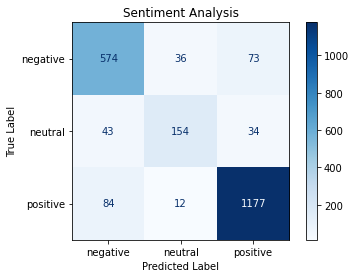

In [ ]:
cm = confusion_matrix(y_test, test)
color = 'black'
matrix = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Sentiment Analysis', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()